# Importing Required Libraries
First, we need to import all the libraries that we will use in this analysis. Matplotlib and seaborn are used for visualization. Scipy is used for statistical analysis. Numpy and pandas are used for data manipulation.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import norm, sem
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Prepping data

In [2]:
df = pd.read_csv("eik.csv", sep=";", decimal=",")

i=7
j=5
k=3

to_delete = [k + 1, 
             j + 1, 
             i+ 1, 
             j*k + 1, 
             i*j + 1, 
             i*k + 1, 
             #i*j*k + 1, not in the set
             i+j+k + 1 ]

df = df.drop(to_delete)

# Data Transformation
We apply log and square root transformations to the 'Volume' and 'Grootte' columns and create new columns for each transformation. We keep the original data for comparison.

In [3]:
transformations = {'Log': np.log, 'Square root': np.sqrt}

for name, function in transformations.items():
    df[name + '_Volume'] = function(df['Volume'])
    df[name + '_Grootte'] = function(df['Grootte'])
    df[name + '_Hoogte'] = function(df['Hoogte'])

# Data Visualization
We will plot histograms and boxplots for original and transformed 'Volume' and 'Grootte' columns.


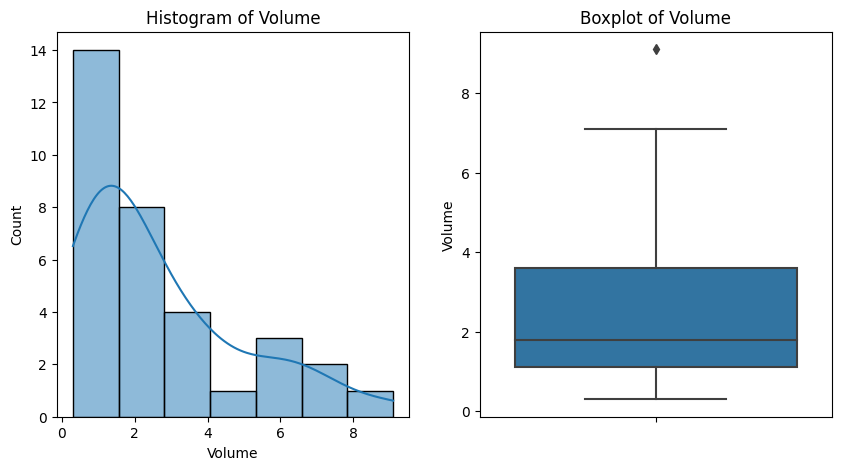

count    33.000000
mean      2.639394
std       2.258033
min       0.300000
25%       1.100000
50%       1.800000
75%       3.600000
max       9.100000
Name: Volume, dtype: float64


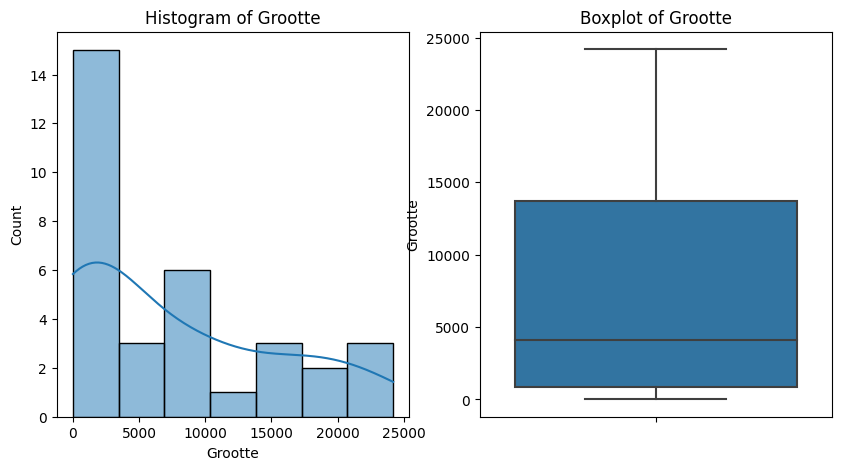

count       33.000000
mean      7568.181818
std       7852.979822
min         13.000000
25%        826.000000
50%       4082.000000
75%      13688.000000
max      24196.000000
Name: Grootte, dtype: float64


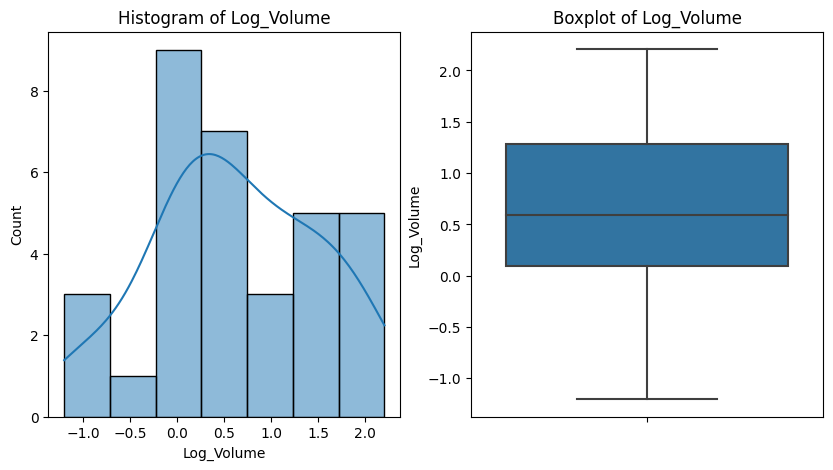

count    33.000000
mean      0.615983
std       0.884560
min      -1.203973
25%       0.095310
50%       0.587787
75%       1.280934
max       2.208274
Name: Log_Volume, dtype: float64


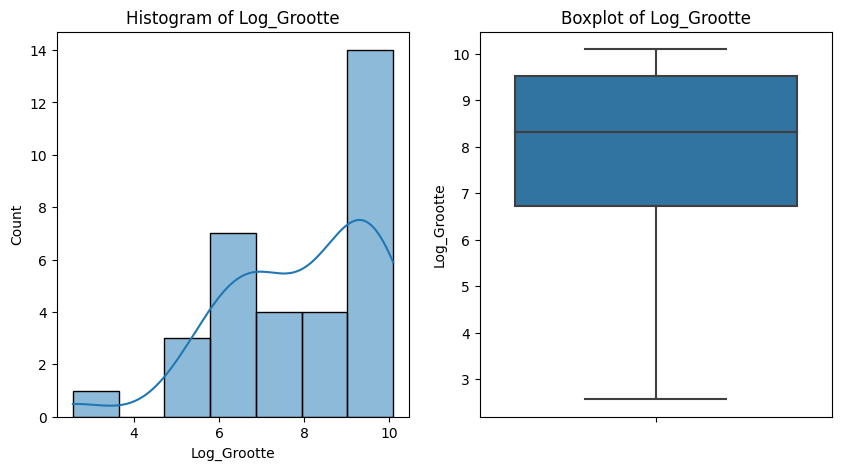

count    33.000000
mean      7.960667
std       1.801473
min       2.564949
25%       6.716595
50%       8.314342
75%       9.524275
max      10.093943
Name: Log_Grootte, dtype: float64


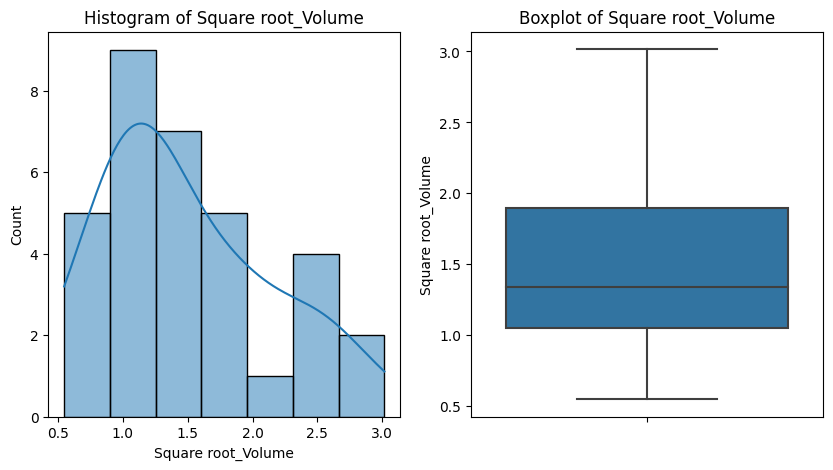

count    33.000000
mean      1.492776
std       0.651045
min       0.547723
25%       1.048809
50%       1.341641
75%       1.897367
max       3.016621
Name: Square root_Volume, dtype: float64


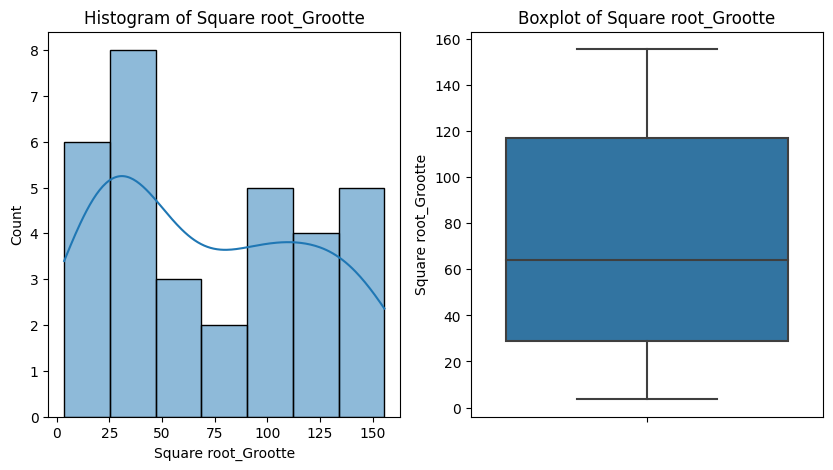

count     33.000000
mean      72.734765
std       48.466670
min        3.605551
25%       28.740216
50%       63.890531
75%      116.995726
max      155.550635
Name: Square root_Grootte, dtype: float64


In [16]:
def plot_hist_boxplot(df, col):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

    plt.show()

    print(df[col].describe())



cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

for col in cols:
    plot_hist_boxplot(df, col)

# QQ Plot
We perform QQ plots to visually assess the normality of original and transformed data.

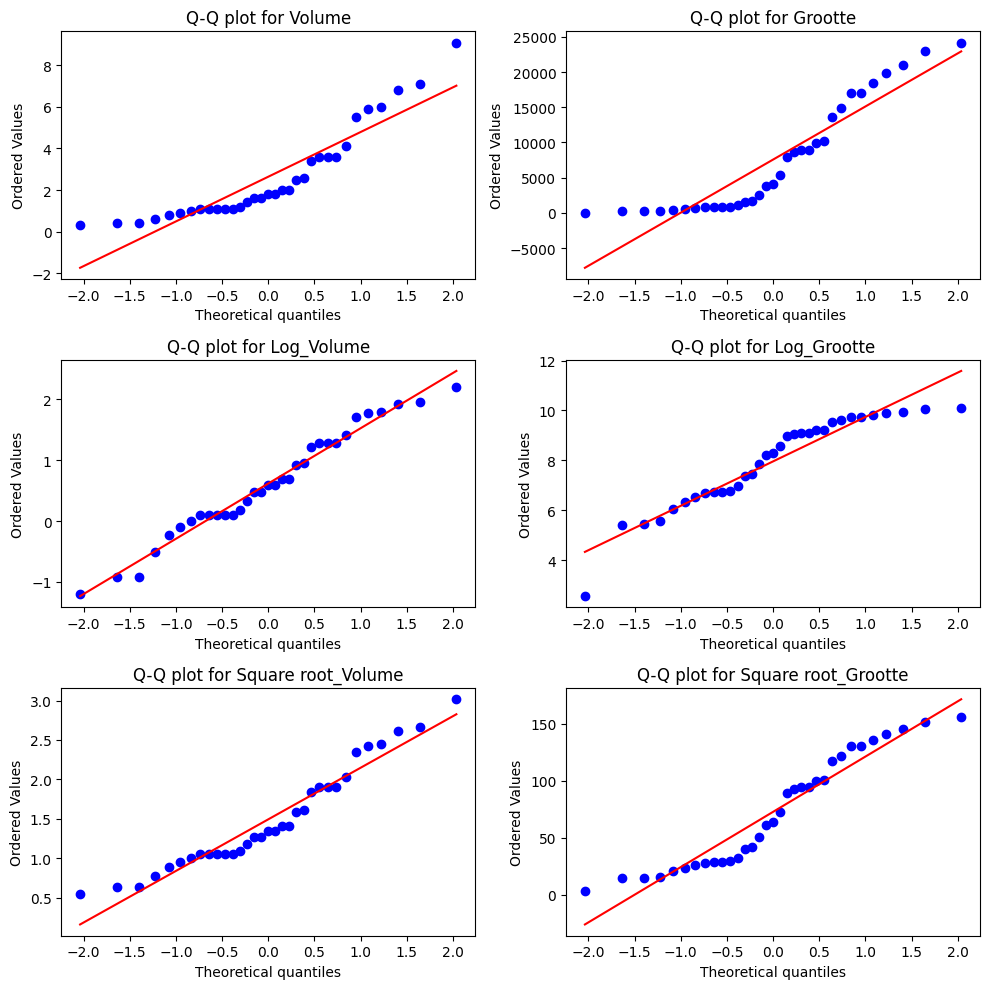

In [25]:
def qq_plot_grid(df, cols):
    # Number of plots
    n = len(cols)
    
    # Define number of rows and columns for plot grid 
    rows = 3
    cols_count = 2
    
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(rows, cols_count, figsize=(10, 10))

    # Counter
    count = 0

    for row in range(rows):
        for col in range(cols_count):
            if count < n:  # To prevent an empty plot in case of less number of plots
                data = df[cols[count]].dropna()
                stats.probplot(data, dist="norm", plot=ax[row, col])
                ax[row, col].set_title(f"Q-Q plot for {cols[count]}")
                count += 1

    # Remove empty plots
    if count < rows * cols_count:
        for idx in range(count, rows * cols_count):
            fig.delaxes(ax.flatten()[idx])

    # Display the plot
    plt.tight_layout()
    plt.show()

cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

qq_plot_grid(df, cols)

# Normality Test
Finally, we will perform the Shapiro-Wilk test on the original and transformed data to test the normality. The null hypothesis is that the data is normally distributed. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed.


In [7]:
def normality_test(df, col):
    # original data
    stat, p = stats.shapiro(df[col].dropna())
    print(f'{col}:')
    print(f"\tW-statistic: {stat}, p-value: {p}")
    if p > 0.05:
        print("\tFail to reject the null hypothesis, the data seems to be normally distributed.")
    else:
        print("\tReject the null hypothesis, the data does not seem to be normally distributed.")

for col in cols:
    normality_test(df, col)

Volume:
	W-statistic: 0.8431628346443176, p-value: 0.00024161198234651238
	Reject the null hypothesis, the data does not seem to be normally distributed.
Grootte:
	W-statistic: 0.8444139957427979, p-value: 0.00025711848866194487
	Reject the null hypothesis, the data does not seem to be normally distributed.
Log_Volume:
	W-statistic: 0.9719041585922241, p-value: 0.5345546007156372
	Fail to reject the null hypothesis, the data seems to be normally distributed.
Log_Grootte:
	W-statistic: 0.9056379795074463, p-value: 0.007484225556254387
	Reject the null hypothesis, the data does not seem to be normally distributed.
Square root_Volume:
	W-statistic: 0.9330432415008545, p-value: 0.04275839403271675
	Reject the null hypothesis, the data does not seem to be normally distributed.
Square root_Grootte:
	W-statistic: 0.9091149568557739, p-value: 0.009260003454983234
	Reject the null hypothesis, the data does not seem to be normally distributed.


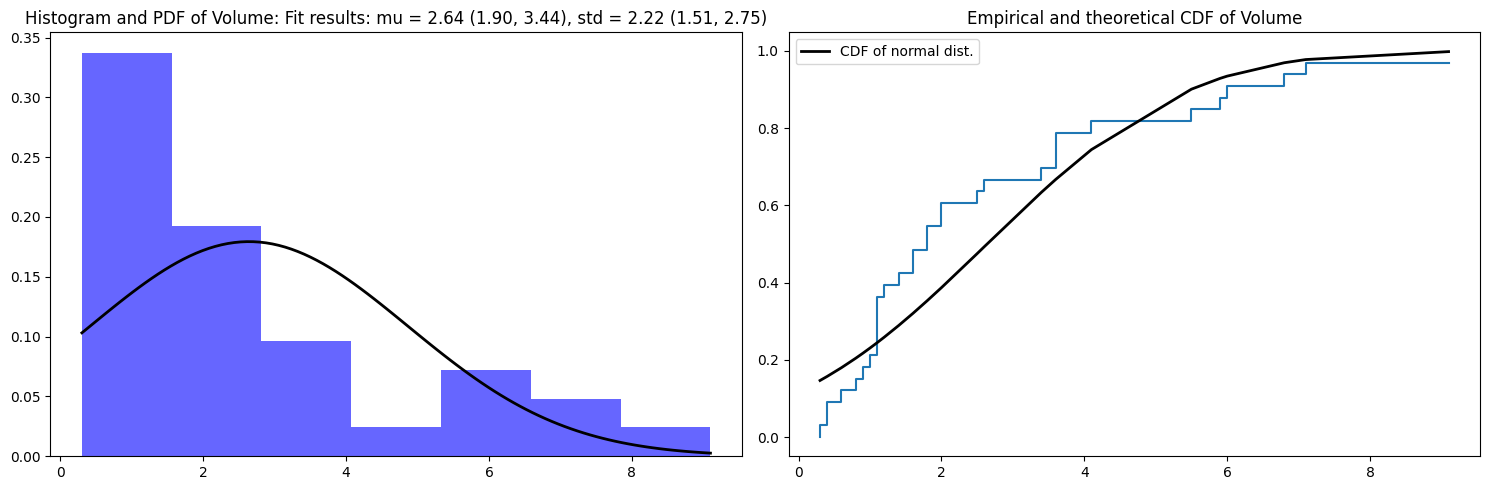

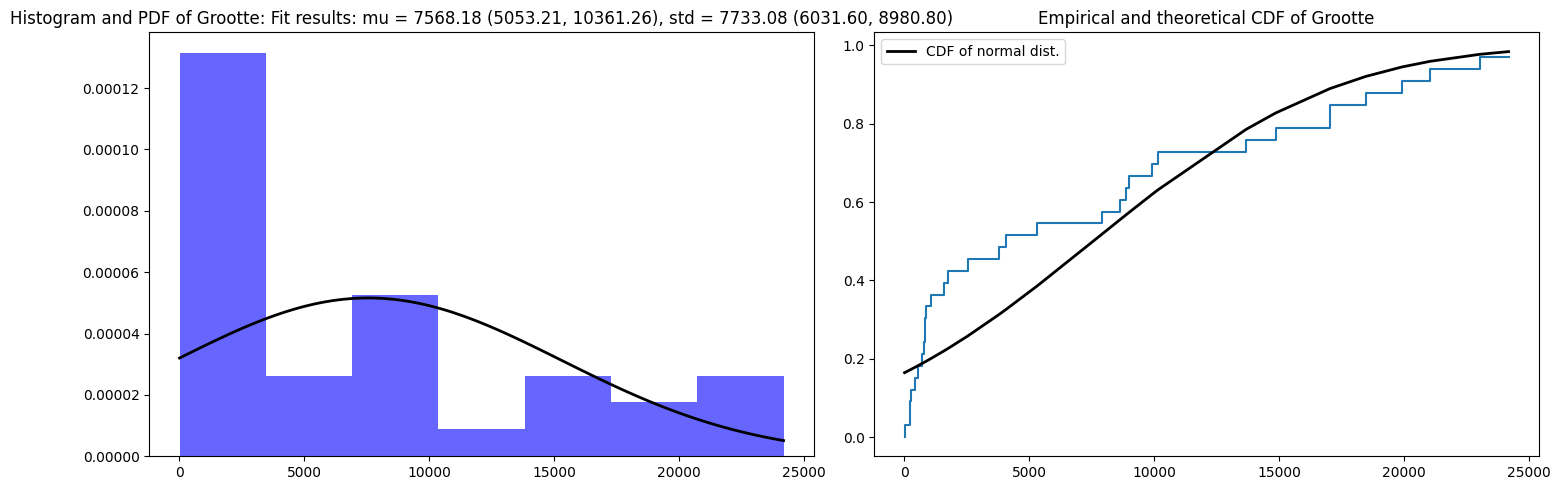

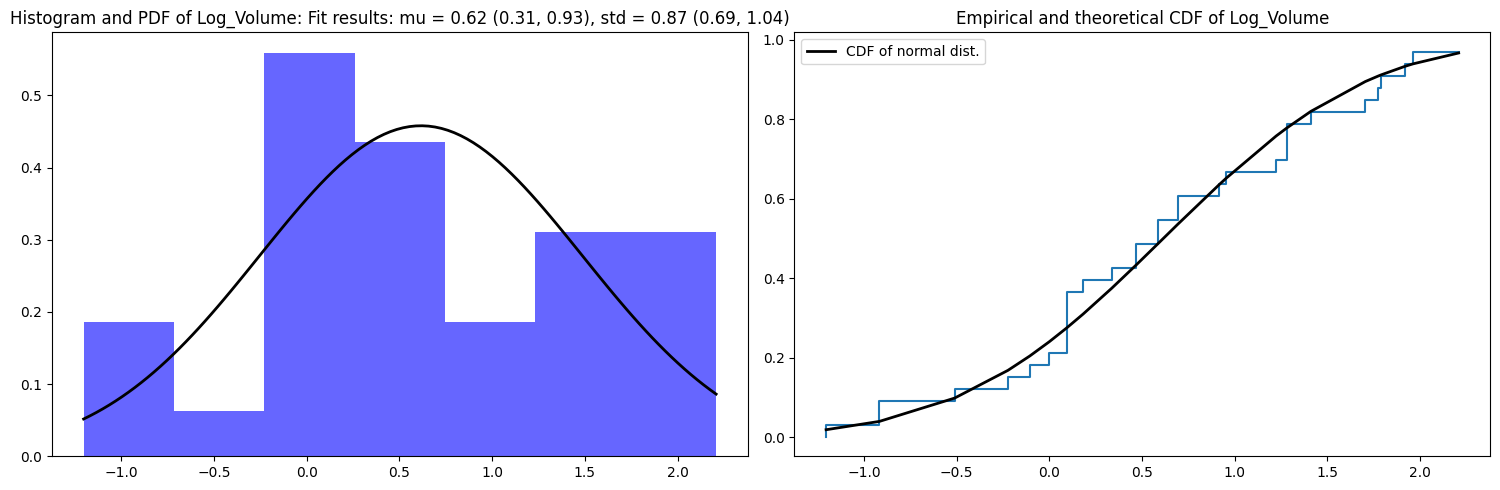

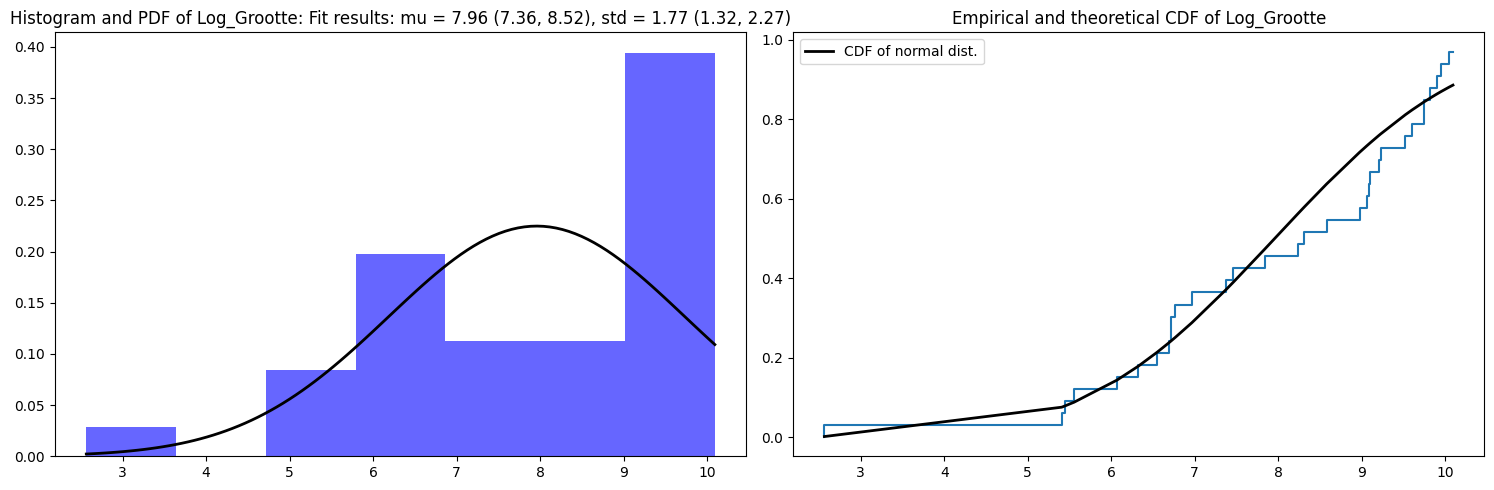

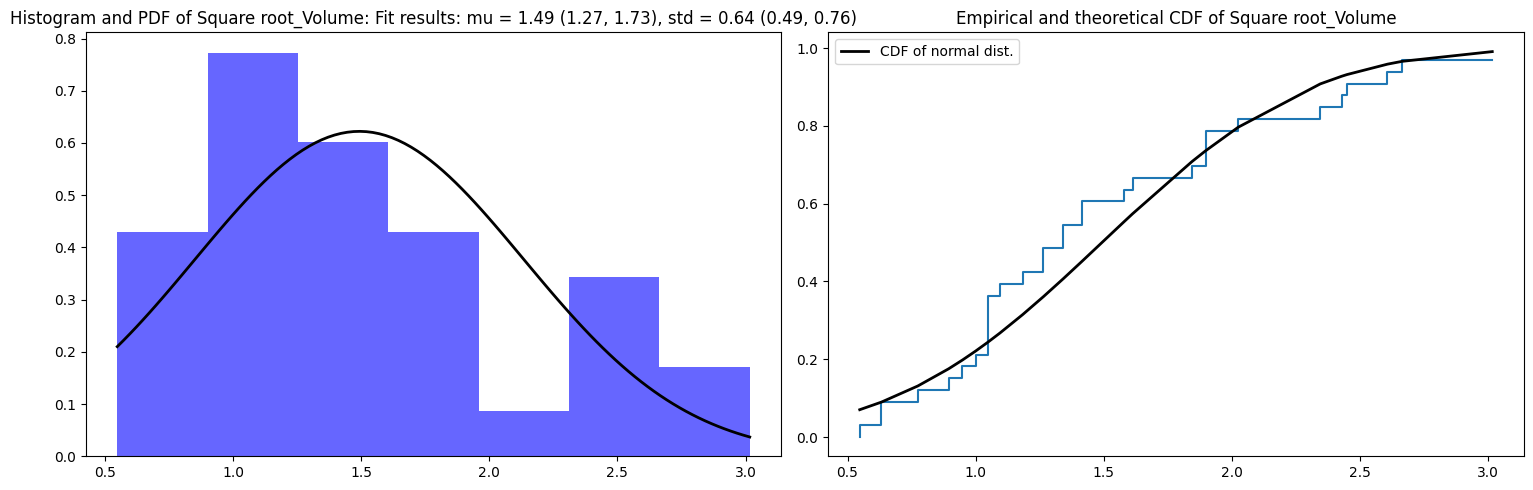

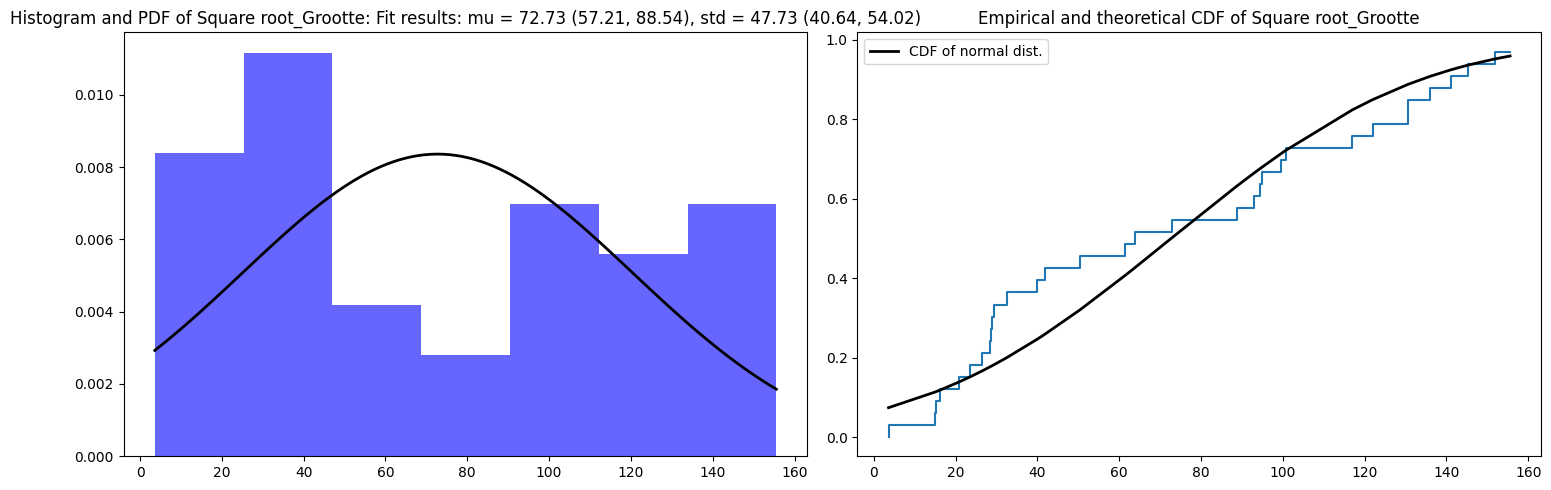

In [46]:
from scipy.stats import norm, sem
from sklearn.utils import resample
import math

def bootstrap_CI(data, n_iterations=1000):
    """Returns 95% Confidence Interval using bootstrapping method"""
    means = np.array([resample(data).mean() for _ in range(n_iterations)])
    stds = np.array([resample(data).std() for _ in range(n_iterations)])

    CI_means = np.percentile(means, [2.5, 97.5])
    CI_stds = np.percentile(stds, [2.5, 97.5])

    return CI_means, CI_stds

def plot_histogram_and_ecdf(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram
    data = df[col].dropna()
    bins = 7
    n, bins, patches = ax1.hist(data, bins=bins, density=True, alpha=0.6, color='b')

    # Estimate parameters of normal distribution
    mu, std = norm.fit(data)

    # Compute Confidence Intervals using bootstrapping
    CI_mu, CI_std = bootstrap_CI(data)

    # Plot the PDF.
    xmin, xmax = min(data), max(data)
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f (%.2f, %.2f), std = %.2f (%.2f, %.2f)" % (mu, CI_mu[0], CI_mu[1], std, CI_std[0], CI_std[1])
    ax1.set_title(f'Histogram and PDF of {col}: {title}')

    # ECDF
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    ax2.step(sorted_data, yvals)

    # Plot normal distribution CDF
    norm_cdf = norm.cdf(sorted_data, mu, std)
    ax2.plot(sorted_data, norm_cdf, 'k', linewidth=2, label='CDF of normal dist.')
    ax2.set_title(f'Empirical and theoretical CDF of {col}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    
# You can then call this function for each column
cols = ['Volume', 'Grootte'] + [f'{name}_{col}' for name in transformations for col in ['Volume', 'Grootte']]

for col in cols:
    plot_histogram_and_ecdf(df, col)


In [9]:
# Define 'large_acorn'
df['large_acorn'] = df['Volume'] >= 3

# Create contingency table
contingency_table = pd.crosstab(df['Regio'], df['large_acorn'])
print(contingency_table)

large_acorn  False  True 
Regio                    
Atlantic        17      6
California       5      5


In [10]:
from scipy.stats import chi2_contingency

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 0.878804347826087
p-value: 0.3485293680989825


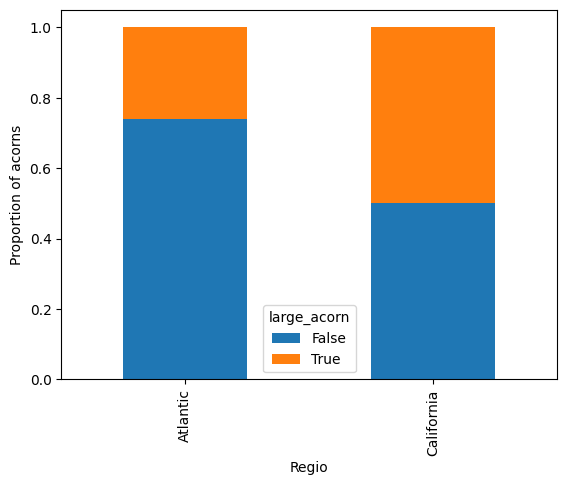

In [11]:
# Normalize the contingency table by total in each row (each region) to get proportions
contingency_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

contingency_norm.plot(kind='bar', stacked=True)
plt.ylabel('Proportion of acorns')
plt.show()

--------------------------------------------------
Performing analysis for the complete dataset
--------------------------------------------------

Regression Results for Complete dataset

                            OLS Regression Results                            
Dep. Variable:                 Hoogte   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.892
Date:                Wed, 14 Jun 2023   Prob (F-statistic):             0.0575
Time:                        00:21:19   Log-Likelihood:                -116.50
No. Observations:                  33   AIC:                             237.0
Df Residuals:                      31   BIC:                             240.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef

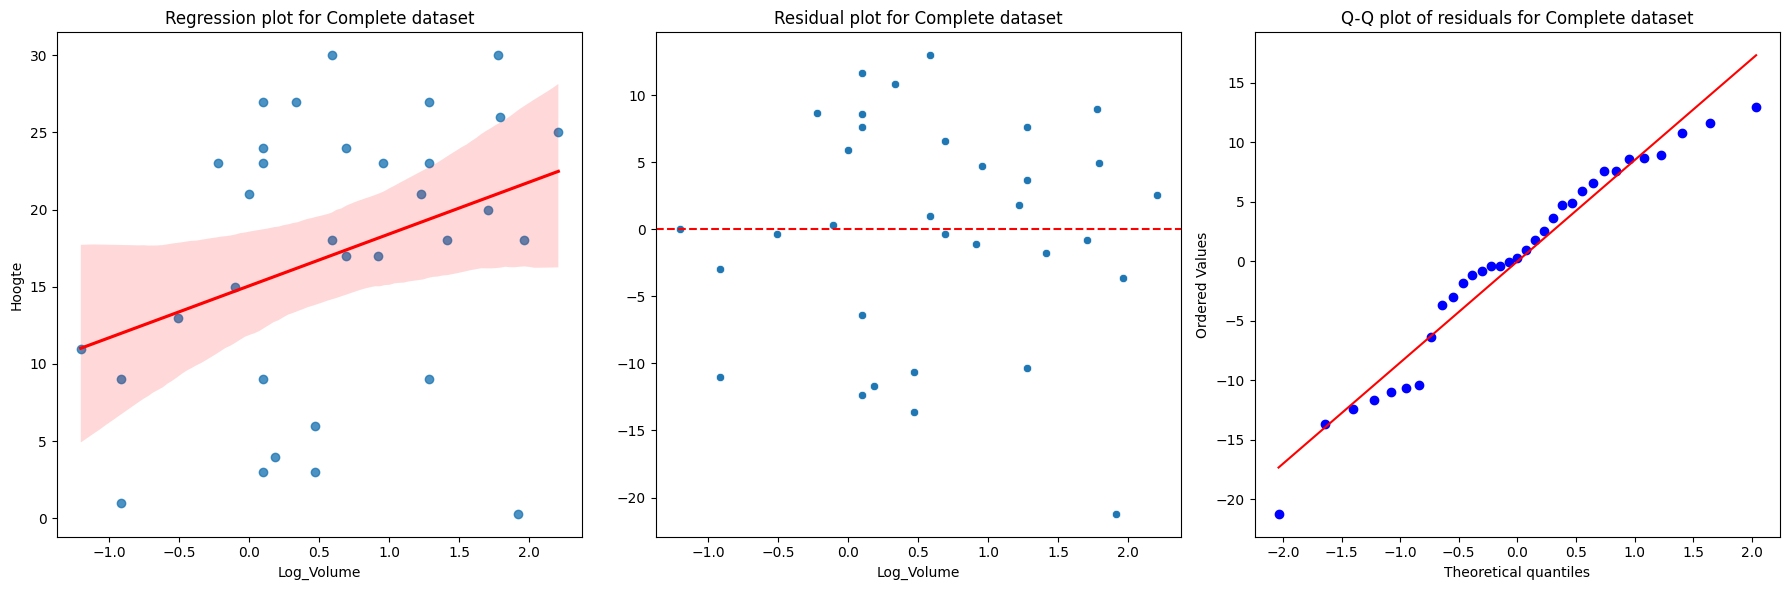

Performing analysis for residuals
Residuals:
	W-statistic: 0.9526273608207703, p-value: 0.15868426859378815
	Fail to reject the null hypothesis, the data seems to be normally distributed.


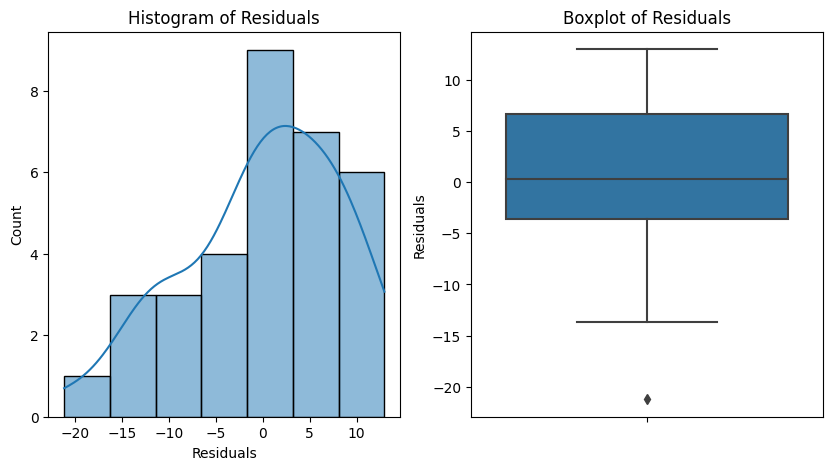

count    3.300000e+01
mean     2.583792e-15
std      8.386628e+00
min     -2.120084e+01
25%     -3.645880e+00
50%      2.930705e-01
75%      6.610463e+00
max      1.296442e+01
Name: Residuals, dtype: float64


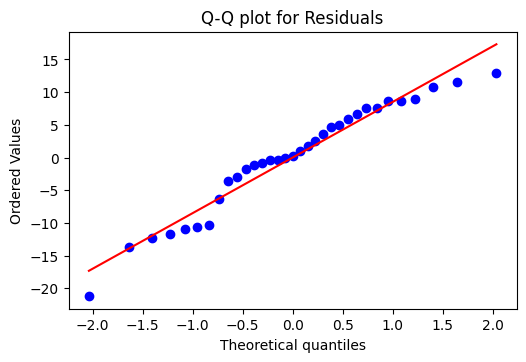

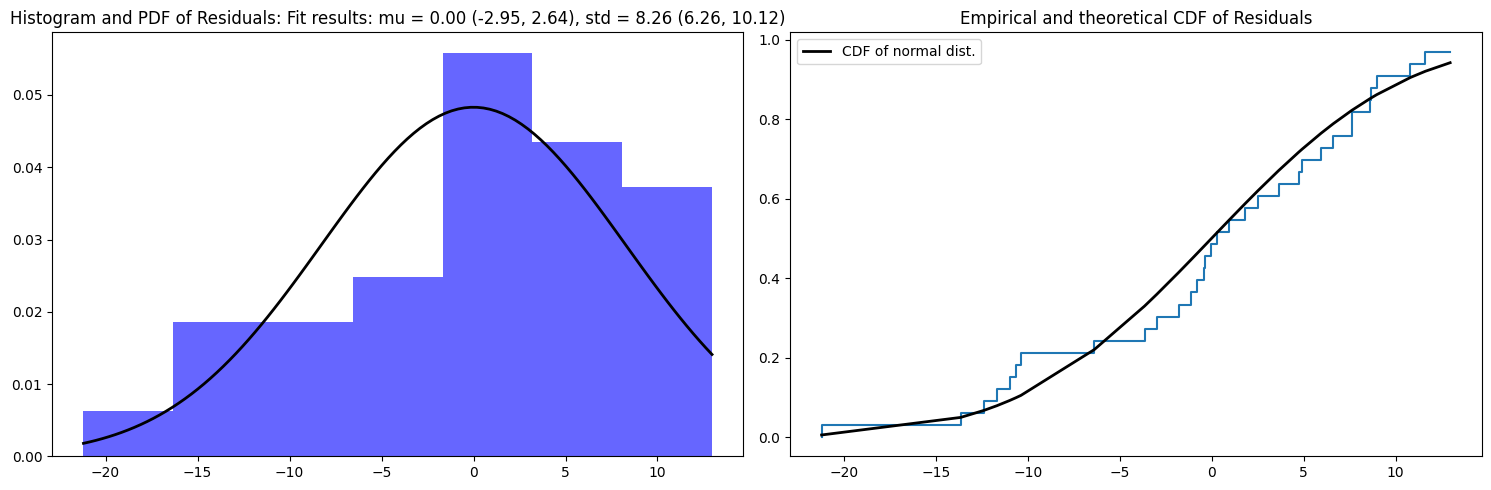

--------------------------------------------------
Performing analysis for group: Regio = Atlantic
--------------------------------------------------

Regression Results for Regio = Atlantic

                            OLS Regression Results                            
Dep. Variable:                 Hoogte   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.5372
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.472
Time:                        00:21:25   Log-Likelihood:                -82.754
No. Observations:                  23   AIC:                             169.5
Df Residuals:                      21   BIC:                             171.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 c

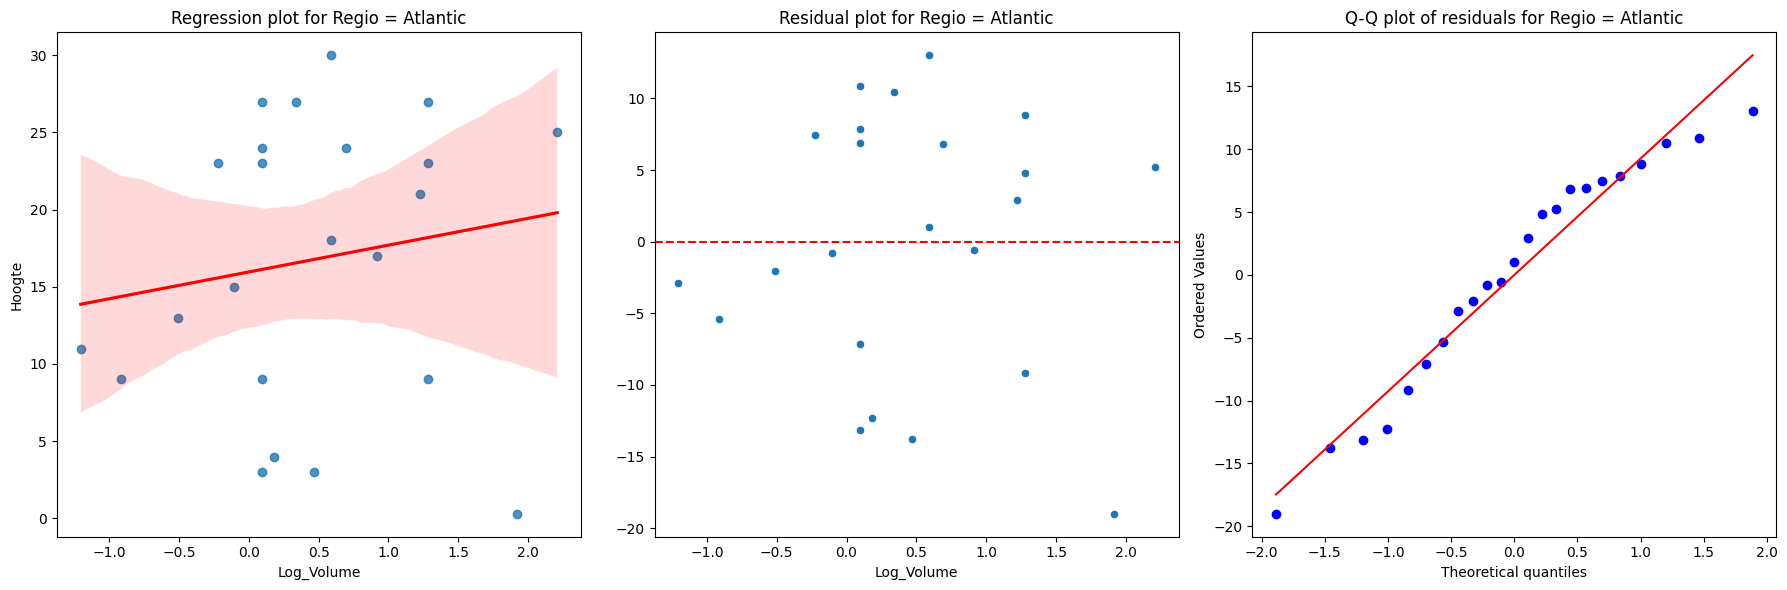

Performing analysis for residuals
Residuals:
	W-statistic: 0.9457244277000427, p-value: 0.23805931210517883
	Fail to reject the null hypothesis, the data seems to be normally distributed.


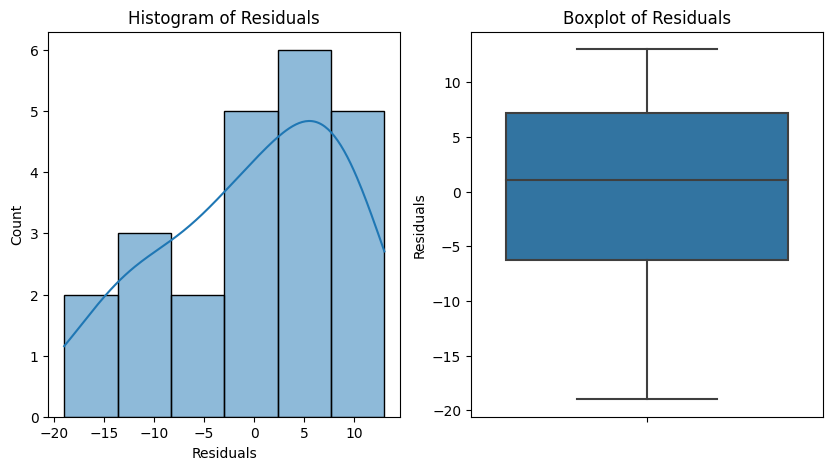

count    2.300000e+01
mean     1.544658e-16
std      9.036597e+00
min     -1.899046e+01
25%     -6.247344e+00
50%      1.018478e+00
75%      7.150598e+00
max      1.301848e+01
Name: Residuals, dtype: float64


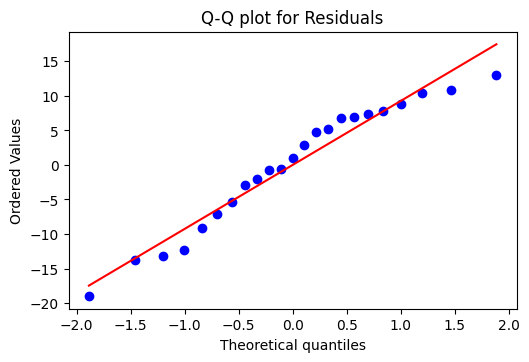

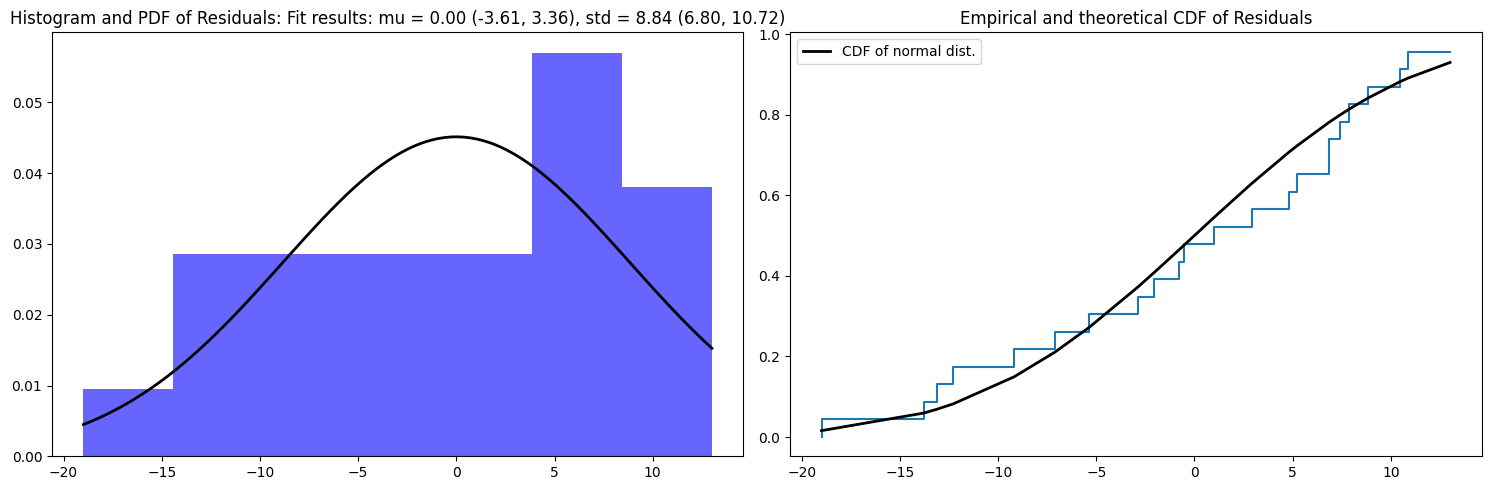

--------------------------------------------------
Performing analysis for group: Regio = California
--------------------------------------------------

Regression Results for Regio = California

                            OLS Regression Results                            
Dep. Variable:                 Hoogte   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     8.904
Date:                Wed, 14 Jun 2023   Prob (F-statistic):             0.0175
Time:                        00:21:29   Log-Likelihood:                -31.547
No. Observations:                  10   AIC:                             67.09
Df Residuals:                       8   BIC:                             67.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
              

/Users/pimvandenbosch/Desktop/UA/Elementaire Statistiek/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


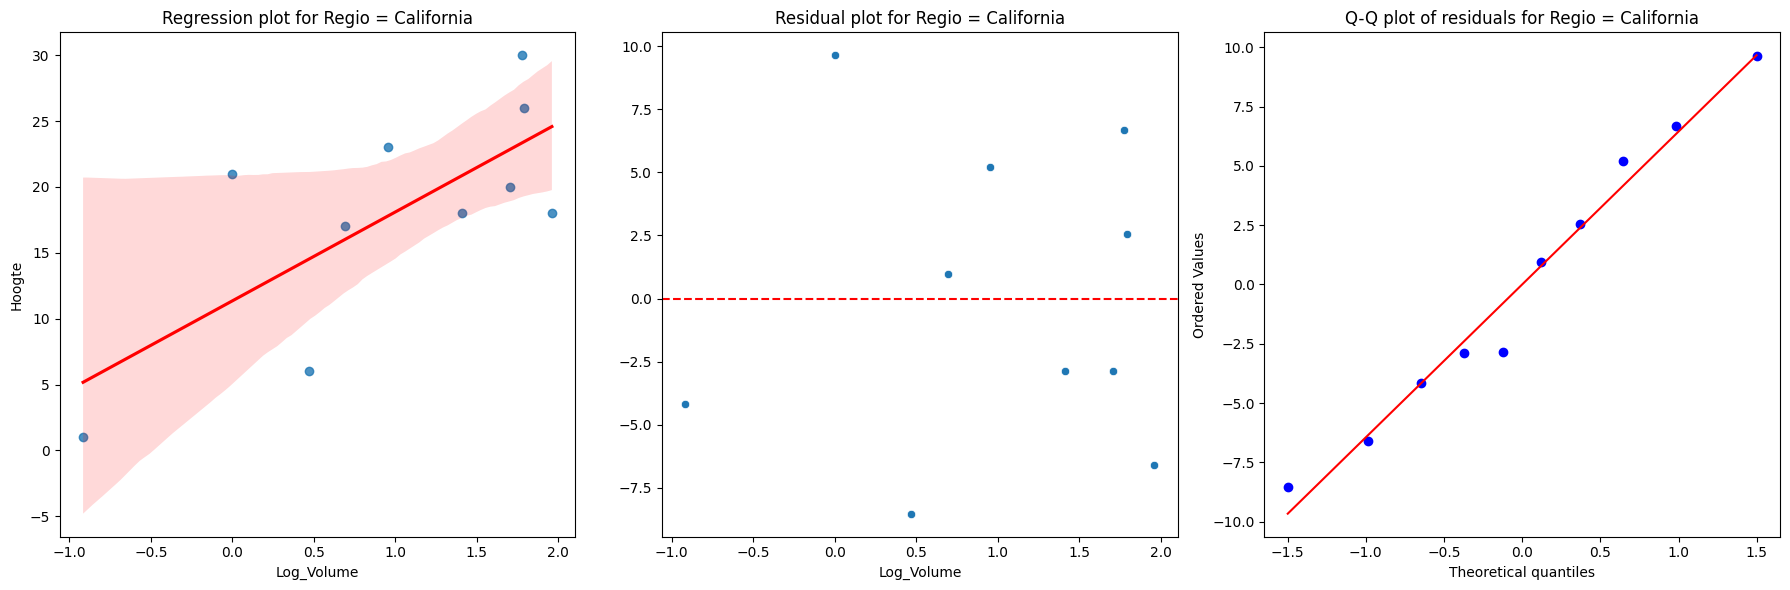

Performing analysis for residuals
Residuals:
	W-statistic: 0.9638506770133972, p-value: 0.8287255764007568
	Fail to reject the null hypothesis, the data seems to be normally distributed.


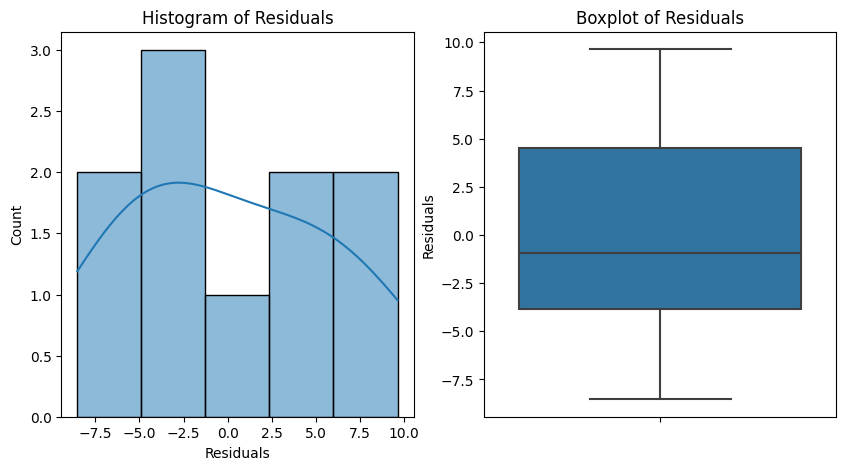

count    1.000000e+01
mean     4.618528e-15
std      5.979834e+00
min     -8.527304e+00
25%     -3.847247e+00
50%     -9.475403e-01
75%      4.534479e+00
max      9.645134e+00
Name: Residuals, dtype: float64


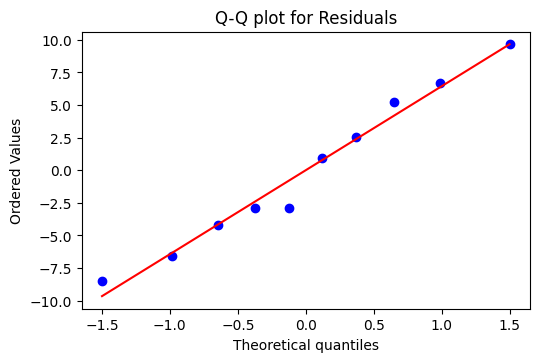

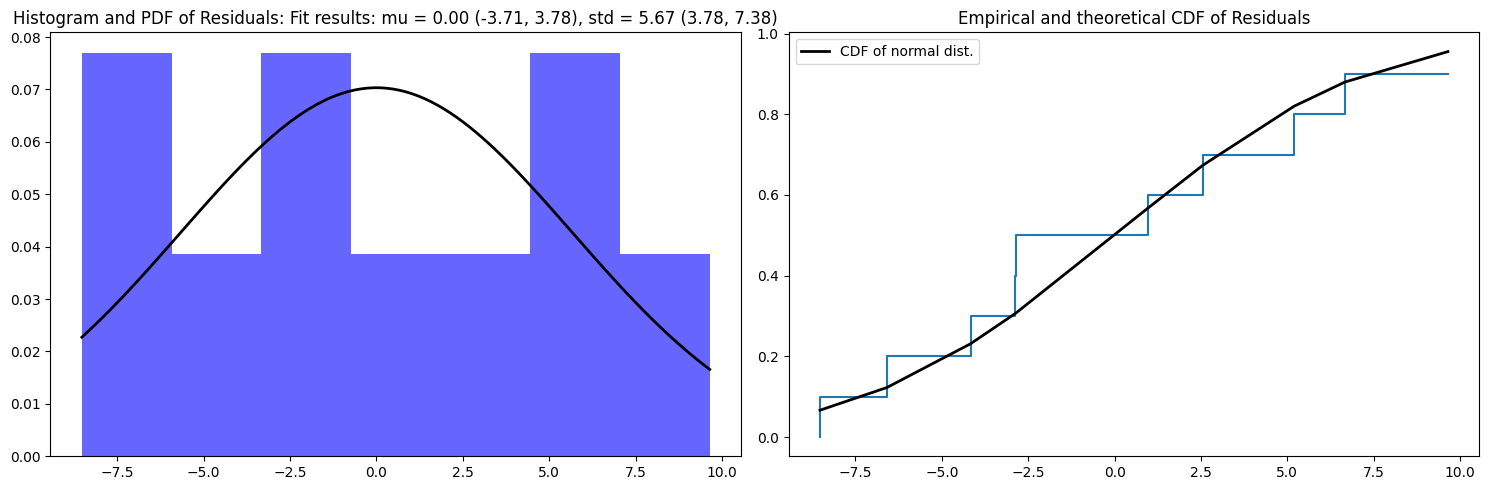

--------------------------------------------------
Performing analysis for group: large_acorn = False
--------------------------------------------------

Regression Results for large_acorn = False

                            OLS Regression Results                            
Dep. Variable:                 Hoogte   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.260
Date:                Wed, 14 Jun 2023   Prob (F-statistic):             0.0861
Time:                        00:21:32   Log-Likelihood:                -77.268
No. Observations:                  22   AIC:                             158.5
Df Residuals:                      20   BIC:                             160.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
            

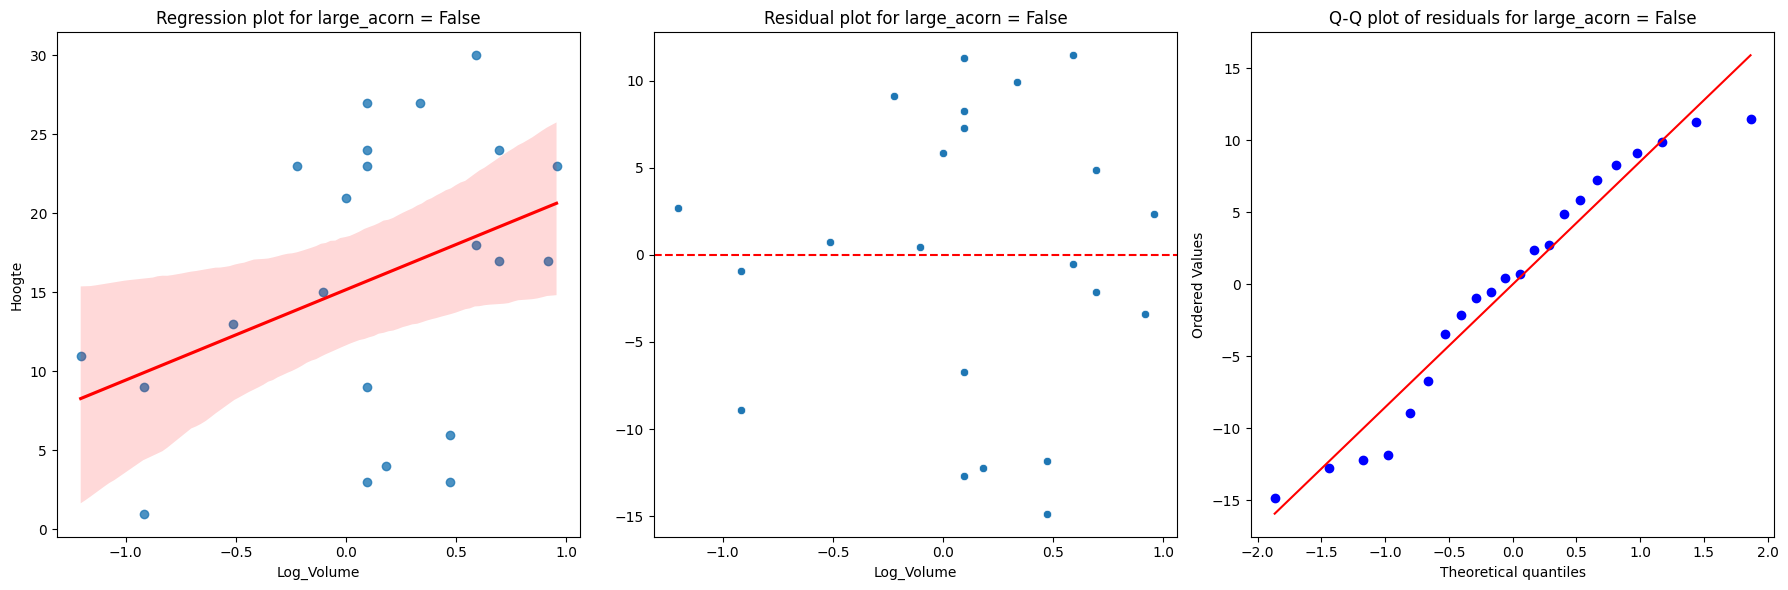

Performing analysis for residuals
Residuals:
	W-statistic: 0.9387774467468262, p-value: 0.18674884736537933
	Fail to reject the null hypothesis, the data seems to be normally distributed.


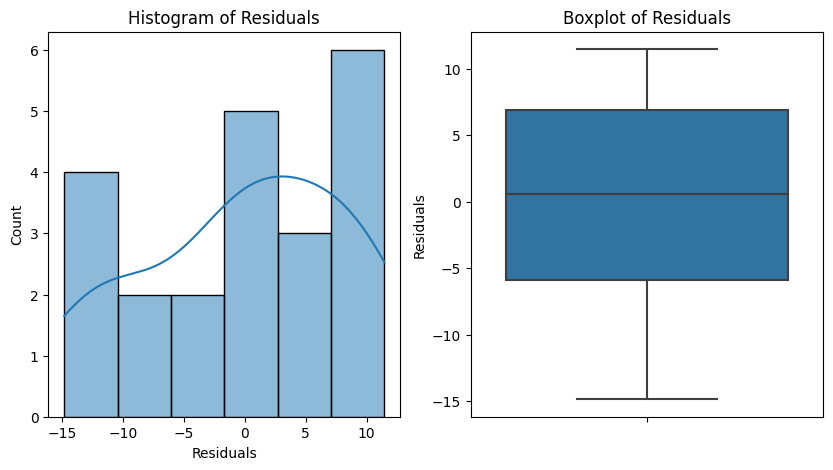

count    2.200000e+01
mean    -1.033517e-14
std      8.301960e+00
min     -1.485892e+01
25%     -5.889424e+00
50%      5.929606e-01
75%      6.921216e+00
max      1.146718e+01
Name: Residuals, dtype: float64


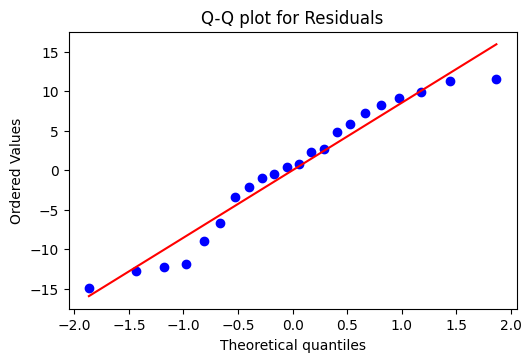

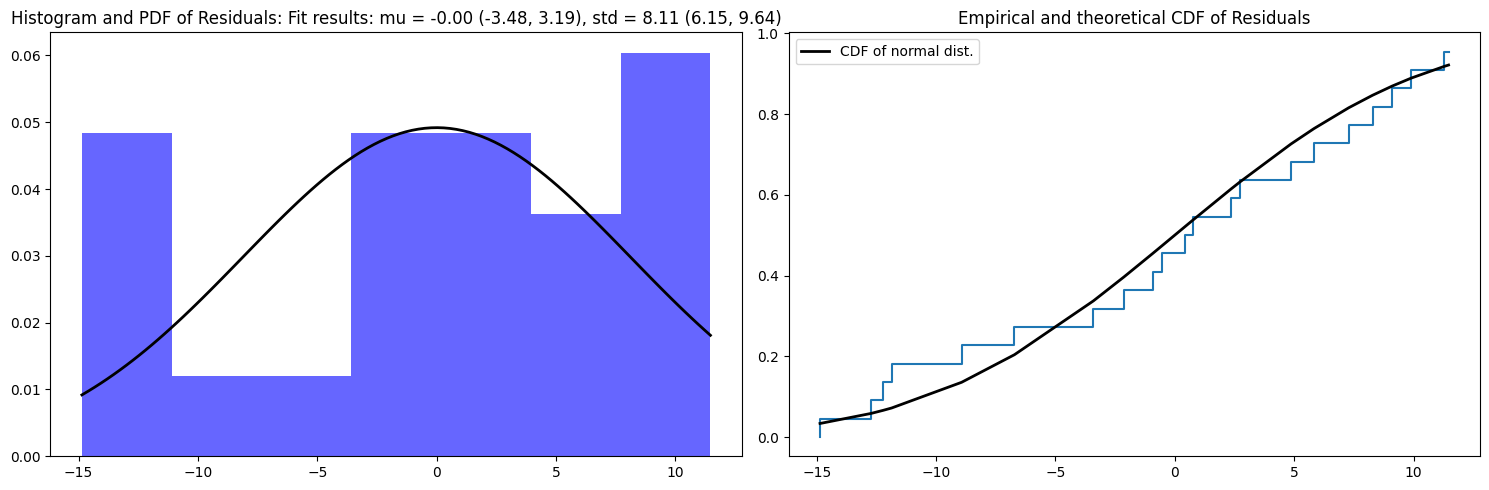

--------------------------------------------------
Performing analysis for group: large_acorn = True
--------------------------------------------------

Regression Results for large_acorn = True

                            OLS Regression Results                            
Dep. Variable:                 Hoogte   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                  0.004382
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.949
Time:                        00:21:36   Log-Likelihood:                -38.727
No. Observations:                  11   AIC:                             81.45
Df Residuals:                       9   BIC:                             82.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
              

/Users/pimvandenbosch/Desktop/UA/Elementaire Statistiek/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


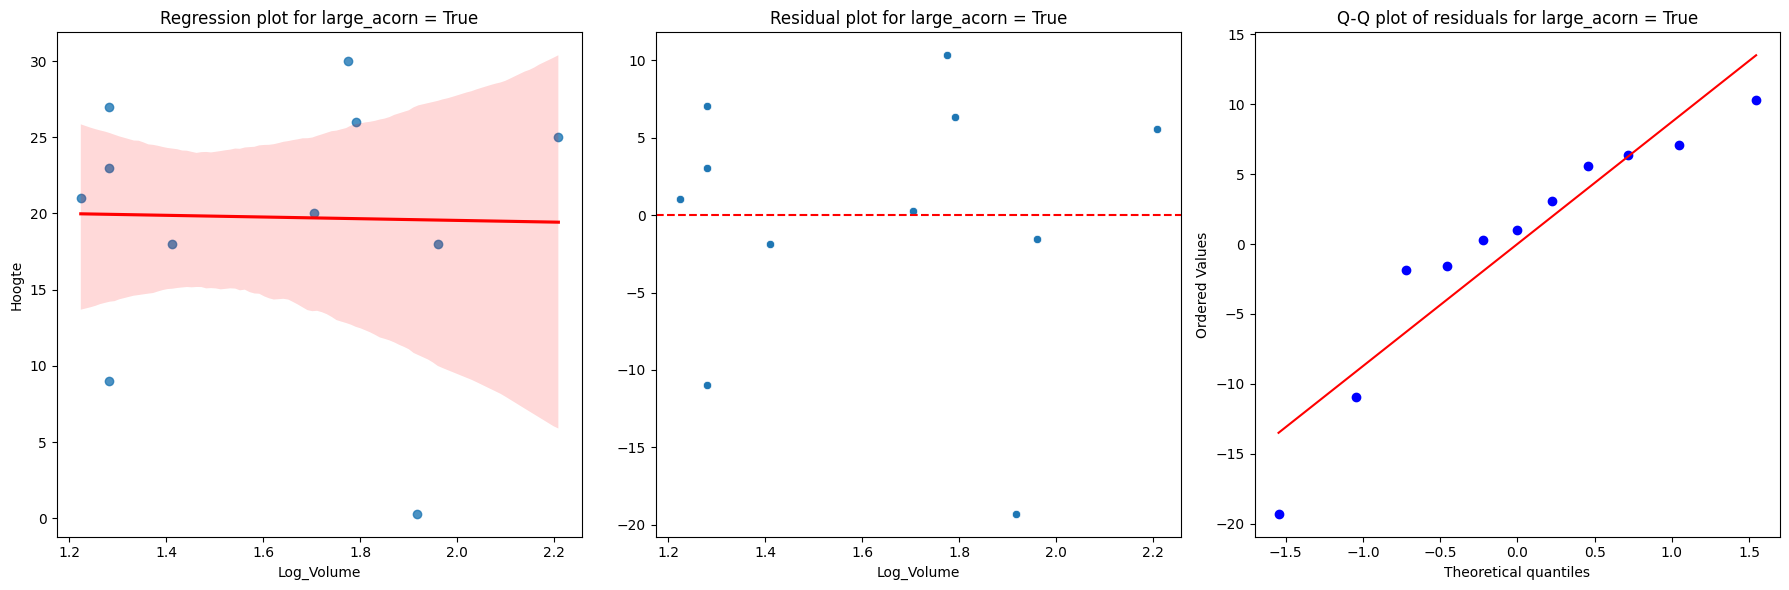

Performing analysis for residuals
Residuals:
	W-statistic: 0.8922395706176758, p-value: 0.14830076694488525
	Fail to reject the null hypothesis, the data seems to be normally distributed.


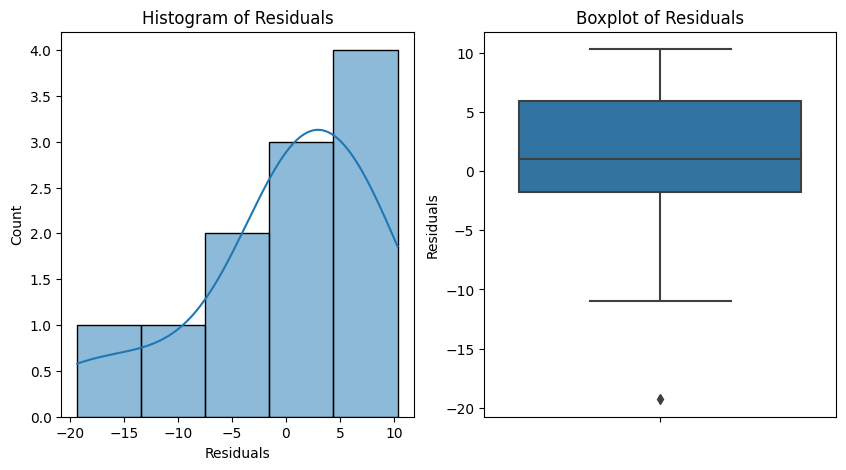

count    1.100000e+01
mean     7.751375e-15
std      8.579445e+00
min     -1.928995e+01
25%     -1.718778e+00
50%      1.024116e+00
75%      5.956320e+00
max      1.033101e+01
Name: Residuals, dtype: float64


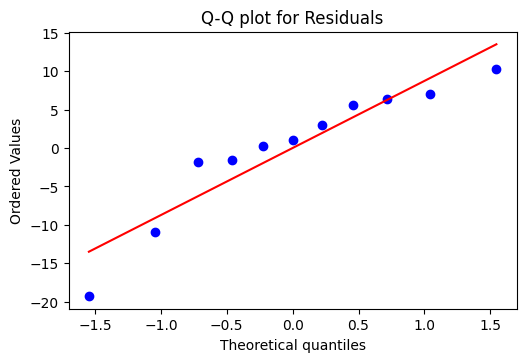

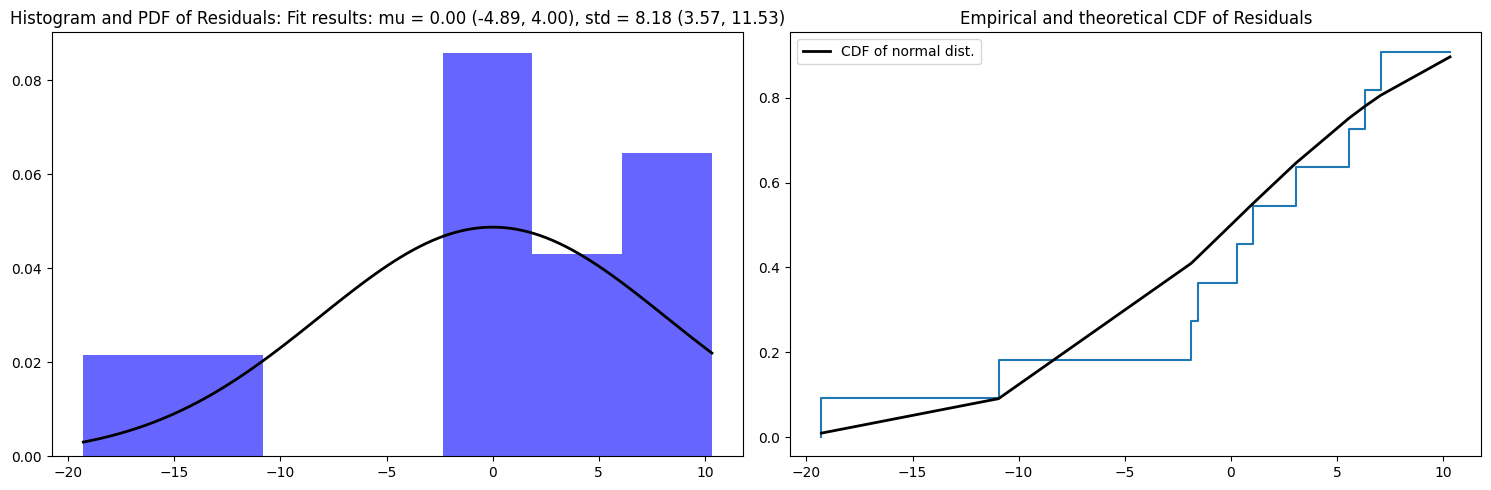

--------------------------------------------------


In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def perform_analysis(df, predictor, response):
    # Analysis for the complete dataset
    print("--------------------------------------------------")
    print("Performing analysis for the complete dataset")
    print("--------------------------------------------------")
    perform_regression_and_plot_residuals(df, predictor, response, 'Complete dataset')
    print("--------------------------------------------------")
    
    
    # Analysis for each group
    for group_by_var in ['Regio', 'large_acorn']:
        groups = df.groupby(group_by_var)
        for name, group in groups:
            print(f"Performing analysis for group: {group_by_var} = {name}")
            print("--------------------------------------------------")
            perform_regression_and_plot_residuals(group, predictor, response, f'{group_by_var} = {name}')
            print("--------------------------------------------------")
    
    """
    # Analysis for each combination of Regio and large_acorn
    groups = df.groupby(['Regio', 'large_acorn'])
    for name, group in groups:
        print(f"Performing analysis for combination: Regio = {name[0]}, Large Acorn = {name[1]}")
        print("--------------------------------------------------")
        perform_regression_and_plot_residuals(group, predictor, response, f'Regio = {name[0]}, Large Acorn = {name[1]}')
        print("--------------------------------------------------")
    """

def perform_regression_and_plot_residuals(df, predictor, response, title_info):
    # Fit the model
    model = smf.ols(f'{response} ~ {predictor}', data=df).fit()

    # Print the summary
    print(f"\nRegression Results for {title_info}\n")
    print(model.summary())

    # Create a figure and axes to place the plots in a row
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the regression line with the data points
    sns.regplot(x=predictor, y=response, data=df, line_kws={'color': 'red'}, ax=axes[0])
    axes[0].set_title(f'Regression plot for {title_info}')

    # Calculate residuals
    residuals = df[response] - model.fittedvalues

    # Plot residuals
    sns.scatterplot(x=df[predictor], y=residuals, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')  # Adds a horizontal line at zero
    axes[1].set_title(f'Residual plot for {title_info}')

    # Q-Q plot of residuals
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title(f'Q-Q plot of residuals for {title_info}')

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
    residuals = pd.DataFrame({'Residuals':residuals})
    
    print(f"Performing analysis for residuals")
    normality_test(residuals, 'Residuals')
    plot_hist_boxplot(residuals, 'Residuals')
    qq_plot_grid(residuals, ['Residuals'])
    plot_histogram_and_ecdf(residuals, 'Residuals')

# Call the function
perform_analysis(df, 'Log_Volume', 'Hoogte')
